Merekam video: 100%|██████████| 1000/1000 [02:44<00:00,  6.07it/s]


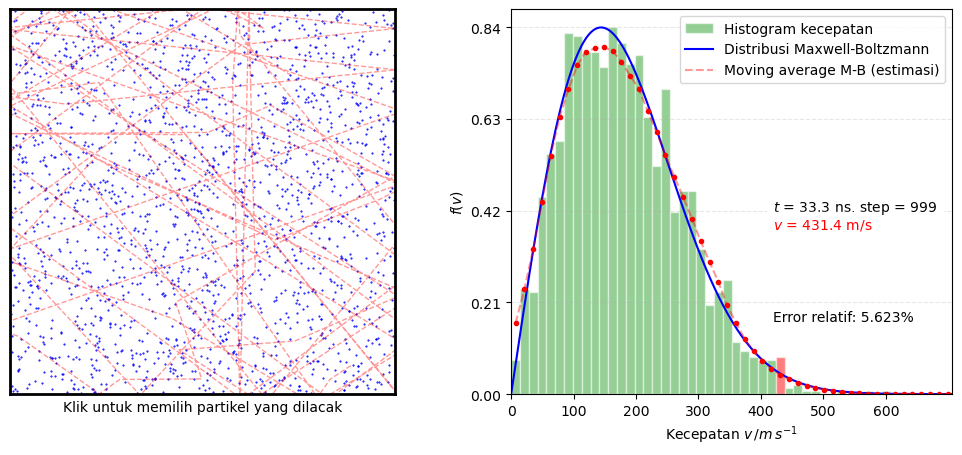

In [ ]:
# Simulasi gas ideal 2D dengan tumbukan elastis antar partikel
# dan tumbukan pantul pada dinding kotak
# Distribusi kecepatan partikel mengikuti distribusi Maxwell-Boltzmann
# dengan animasi gerakan partikel dan histogram kecepatan
# Yoyok Adisetio Laksono, 2025
# Departemen Fisika, FMIPA, Universitas Negeri Malang
#
# Program ini adalah bahan perkuliahan Fisika Komputasi Lanjut
# dan dapat digunakan, dimodifikasi, dan disebarluaskan

import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.interpolate import make_interp_spline
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from tqdm import tqdm

X, Y = 0, 1

class GasIdeal:
    def __init__(self, pos, kec, r, m):
        self.pos = np.asarray(pos, dtype=float)
        self.kec = np.asarray(kec, dtype=float)
        self.n = self.pos.shape[0]
        self.r = r
        self.m = m
        self.nsteps = 0

    def advance(self, dt):
        self.nsteps += 1
        self.pos += self.kec * dt
        dist = squareform(pdist(self.pos))
        iarr, jarr = np.where(dist < 2 * self.r)
        k = iarr < jarr
        iarr, jarr = iarr[k], jarr[k]
        # Periksa apakah menumbuk 4 dinding?
        dinding_kiri = self.pos[:, X] < self.r
        dinding_kanan = self.pos[:, X] > 1 - self.r
        dinding_bawah = self.pos[:, Y] < self.r
        dinding_atas = self.pos[:, Y] > 1 - self.r
        # Partikel yang menumbuk dinding dibalik kecepatannya
        self.kec[dinding_kiri | dinding_kanan, X] *= -1
        self.kec[dinding_bawah | dinding_atas, Y] *= -1
        # Proses tumbukan antar partikel
        for i, j in zip(iarr, jarr): # iterasi semua pasangan yang menumbuk
            # Koordinat relatif dan kecepatan relatif
            pos_i, kec_i = self.pos[i], self.kec[i]
            pos_j, kec_j = self.pos[j], self.kec[j]
            rel_pos, rel_kec = pos_i - pos_j, kec_i - kec_j
            r_rel = rel_pos @ rel_pos
            v_rel = rel_kec @ rel_pos
            v_rel = 2 * rel_pos * v_rel / r_rel - rel_kec
            v_cm = (kec_i + kec_j) / 2
            self.kec[i] = v_cm - v_rel / 2
            self.kec[j] = v_cm + v_rel / 2

def get_speeds(kec):
    return np.hypot(kec[:, X], kec[:, Y])

def get_KE(speeds):
    return 0.5 * sim.m * sum(speeds**2)

def moving_average(data, window=5):
    pad = window // 2
    padded = np.pad(data, (pad, pad), mode='edge')
    kernel = np.ones(window) / window
    return np.convolve(padded, kernel, mode='valid')

#########################################################################
# Parameter simulasi
#########################################################################
n = 2000
skala_r = 5.e6
r = 2e-10 * skala_r
skala_t = 1e9
sbar = 353 * skala_r / skala_t
FPS = 30
dt = 1 / FPS
m = 1

pos = np.random.random((n, 2))
theta = np.random.random(n) * 2 * np.pi
s0 = sbar * np.random.random(n)
kec = (s0 * np.array((np.cos(theta), np.sin(theta)))).T

# Membuat objek simulasi gas ideal
sim = GasIdeal(pos, kec, r, m)
# Indeks partikel yang dilacak
tracked_index = 0
track_history = []

# Pengaturan gambar
DPI = 100
width, height = 1000, 500
fig = plt.figure(figsize=(width / DPI, height / DPI), dpi=DPI)
fig.canvas.manager.set_window_title("Simulasi Gas Ideal, Yoyok Adisetio Laksono, 2025")
fig.subplots_adjust(left=0, right=0.97)
# Membuat dua subplot: simulasi dan histogram kecepatan
# subplot 1: gerakan gas ideal
sim_ax = fig.add_subplot(121, aspect='equal', autoscale_on=False)
sim_ax.set_xticks([]); sim_ax.set_yticks([])
sim_ax.set_xlabel('Klik untuk memilih partikel yang dilacak')
for spine in sim_ax.spines.values(): spine.set_linewidth(2)
# subplot 2: grafik histogram kecepatan analitik, simulasi, dan satu partikel terpilih
speed_ax = fig.add_subplot(122)
speed_ax.set_xlabel(r'Kecepatan $v\,/m\,s^{-1}$')
speed_ax.set_ylabel(r'$f(v)$')
particles, = sim_ax.plot([], [], 'bo', ms=24)
track_line, = sim_ax.plot([], [], 'r--', lw=1, label='Jejak partikel terpilih', alpha=0.4)
# Histogram kecepatan awal
speeds = get_speeds(sim.kec)
nbins = 50 # 50 histogram bins
hist_vals, bins, bar_container = speed_ax.hist(
    speeds, bins=nbins, range=(0, 2 * sbar), density=True,
    color='tab:green', edgecolor='w', alpha=0.5,
    label='Histogram kecepatan'
)
bar_container_ref = bar_container
speed_ax.set_xlim(0, 2 * sbar)
ticks = np.linspace(0, 600, 7, dtype=int)
speed_ax.set_xticks(ticks * skala_r / skala_t)
speed_ax.set_xticklabels([str(tick) for tick in ticks])
speed_ax.set_yticks([])
speed_ax.grid(axis='y', linestyle='--', alpha=0.3)
# Hitung energi kinetik rerata, kecepatan rms, dan kecepatan maks
mean_KE = get_KE(speeds) / n
a = sim.m / 2 / mean_KE
sgrid_hi = np.linspace(0, bins[-1], 200)
f = 2 * a * sgrid_hi * np.exp(-a * sgrid_hi**2)
mb_line, = speed_ax.plot(sgrid_hi, f, 'b-', label='Distribusi Maxwell-Boltzmann')
fmax = np.sqrt(sim.m / mean_KE / np.e)
speed_ax.set_yticks(np.linspace(0, fmax, 5))
speed_ax.set_yticklabels([f'{v:.2f}' for v in np.linspace(0, fmax, 5)])
# Grafik kecepatan moving average dan titik merah puncak histogram
sgrid = (bins[1:] + bins[:-1]) / 2
mb_est_line, = speed_ax.plot([], [], 'r--', label='Moving average M-B (estimasi)', alpha=0.4)
mb_est = np.zeros(len(sgrid))
peak_dots, = speed_ax.plot([], [], 'ro', markersize=3) #, label='Puncak histogram')
# Posisi label
xlabel, ylabel = 0.6 * sgrid[-1], 0.5 * fmax
label = speed_ax.text(xlabel, ylabel, '', backgroundcolor='w')
speed_label = speed_ax.text(xlabel, 0.9*ylabel, '', color='red', fontsize=10, backgroundcolor='w')
# Error relatif
error_text = speed_ax.text(xlabel, 0.4*ylabel, '', fontsize=10, color='black', backgroundcolor='w')
speed_ax.legend(loc='upper right')

# Fungsi inisialisasi animasi
def init_anim():
    particles.set_data([], [])
    track_line.set_data([], [])
    mb_est_line.set_data([], [])
    peak_dots.set_data([], [])
    label.set_text('')
    speed_label.set_text('')
    error_text.set_text('')
    return particles, track_line, mb_est_line, peak_dots, label, speed_label, *bar_container_ref.patches

# Fungsi animasi
def animate(i):
    global sim, mb_est_line, mb_est, track_history, tracked_index
    sim.advance(dt)
    particles.set_data(sim.pos[:, X], sim.pos[:, Y])
    particles.set_markersize(0.5)

    # Update jejak partikel terpilih
    track_history.append(sim.pos[tracked_index].copy())
    if len(track_history) > 1:
        track_line.set_data(*zip(*track_history))

    # Update histogram kecepatan
    speeds = get_speeds(sim.kec)
    hist_vals, _ = np.histogram(speeds, bins=bins, density=True)
    for idx, (count, patch) in enumerate(zip(hist_vals, bar_container_ref.patches)):
        patch.set_height(count)
        patch.set_facecolor('tab:green')

    # Warna merah balok histogram untuk partikel terpilih
    tracked_speed = speeds[tracked_index]
    bin_index = np.searchsorted(bins, tracked_speed) - 1
    if 0 <= bin_index < len(bar_container_ref.patches):
        bar_container_ref.patches[bin_index].set_facecolor('red')

    # Update label gambar kurva distribusi kecepatan
    if i >= IAV_START:
        mb_est += (hist_vals - mb_est) / (i - IAV_START + 1)
        # Menghitung moving average untuk memperhalus kurva histogram
        smoothed = moving_average(mb_est, window=5)
        mb_est_line.set_data(sgrid, smoothed)
        # Menampilkan titik puncak pada histogram
        peak_dots.set_data(sgrid, smoothed)
        # Interpolasi distribusi analitik ke grid sgrid
        f_interp = 2 * a * sgrid * np.exp(-a * sgrid**2)
        # Hitung error relatif
        error_rel = np.linalg.norm(smoothed - f_interp) / np.linalg.norm(f_interp)
        error_text.set_text(f'Error relatif: {error_rel:.3%}')

    label.set_text('$t$ = {:.1f} ns, step = {:d}'.format(i * dt, i))
    speed_label.set_text('$v$ = {:.1f} m/s'.format(tracked_speed * skala_t / skala_r))
    return particles, track_line, mb_est_line, peak_dots, label, speed_label, error_text, *bar_container_ref.patches

# Membuat sejarah jejak partikel saat diklik
# Partikel yang dipilih berjarak terdekat dengan posisi klik
# Tampilan jejak partikel ditampilkan sebagai garis putus-putus merah dan histogram kecepatan merah
def on_click(event):
    global tracked_index, track_history
    if event.inaxes != sim_ax:
        return
    click_pos = np.array([event.xdata, event.ydata])
    distances = np.linalg.norm(sim.pos - click_pos, axis=1)
    tracked_index = np.argmin(distances)
    track_history = [sim.pos[tracked_index].copy()]  # Mulai jejak baru dari posisi saat ini

# Hubungkan event klik ke fungsi on_click
fig.canvas.mpl_connect('button_press_event', on_click)

# Jalankan animasi
IAV_START = 1 # Mulai moving average setelah frame ke-IAV_START
# Tentukan jumlah frame
frames = 1000

anim = FuncAnimation(fig, animate, frames=frames, interval=10, blit=True, init_func=init_anim, repeat=False, cache_frame_data=False)
# plt.tight_layout() # agar subplot tidak saling tumpang tindih
# plt.show()

# Simpan sebagai file MP4
# dengan progress bar agar bisa diketahui prosesnya berapa lama
# Uncomment bagian berikut untuk menyimpan animasi ke video

from matplotlib.animation import FFMpegWriter
# Setup writer
writer = FFMpegWriter(fps=30, metadata=dict(artist='Yoyok'), bitrate=1800)
# Simpan video dengan progress bar
with writer.saving(fig, "simulasi_gas_ideal.mp4", dpi=100):
    for frame in tqdm(range(frames), desc="Merekam video"):
        animate(frame)
        writer.grab_frame()


MENAMBAHKAN KOMPONEN 3D

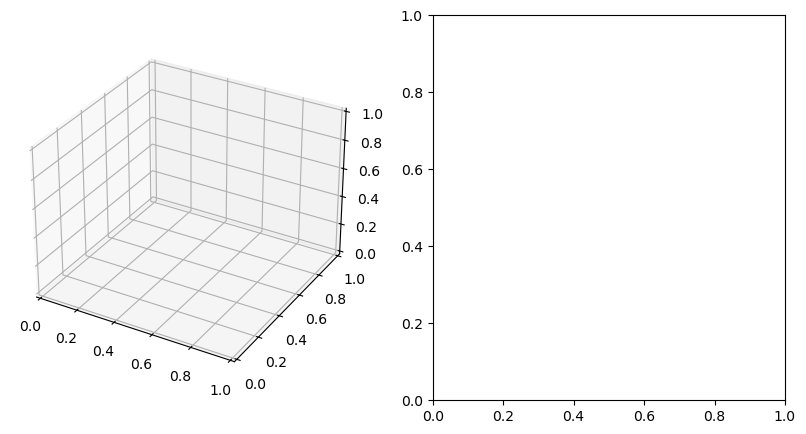

In [3]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D  # <-- add for 3D
from tqdm import tqdm

X, Y, Z = 0, 1, 2  # <-- tambah koordinat Z

class GasIdeal3D:
    def __init__(self, pos, kec, r, m):
        self.pos = np.asarray(pos, dtype=float)
        self.kec = np.asarray(kec, dtype=float)
        self.n = self.pos.shape[0]
        self.r = r
        self.m = m
        self.nsteps = 0

    def advance(self, dt):
        self.nsteps += 1
        self.pos += self.kec * dt
        dist = squareform(pdist(self.pos))
        iarr, jarr = np.where(dist < 2 * self.r)
        k = iarr < jarr
        iarr, jarr = iarr[k], jarr[k]

        # tumbukan dinding 3D
        dinding_xmin = self.pos[:, X] < self.r
        dinding_xmax = self.pos[:, X] > 1 - self.r
        dinding_ymin = self.pos[:, Y] < self.r
        dinding_ymax = self.pos[:, Y] > 1 - self.r
        dinding_zmin = self.pos[:, Z] < self.r
        dinding_zmax = self.pos[:, Z] > 1 - self.r

        self.kec[dinding_xmin | dinding_xmax, X] *= -1
        self.kec[dinding_ymin | dinding_ymax, Y] *= -1
        self.kec[dinding_zmin | dinding_zmax, Z] *= -1

        # tumbukan antar partikel
        for i, j in zip(iarr, jarr):
            pos_i, kec_i = self.pos[i], self.kec[i]
            pos_j, kec_j = self.pos[j], self.kec[j]
            rel_pos, rel_kec = pos_i - pos_j, kec_i - kec_j
            r_rel = rel_pos @ rel_pos
            v_rel = rel_kec @ rel_pos
            v_rel = 2 * rel_pos * v_rel / r_rel - rel_kec
            v_cm = (kec_i + kec_j) / 2
            self.kec[i] = v_cm - v_rel / 2
            self.kec[j] = v_cm + v_rel / 2

def get_speeds(kec):
    return np.sqrt(np.sum(kec**2, axis=1))   # <-- update ke 3D



pos = np.random.random((n, 3))   # <-- dari (n,2) jadi (n,3)
theta = np.random.random(n) * 2 * np.pi
phi = np.arccos(2*np.random.random(n)-1)   # sudut polar (distribusi seragam di bola)
s0 = sbar * np.random.random(n)
kec = np.zeros((n, 3))
kec[:,0] = s0 * np.sin(phi) * np.cos(theta)   # vx
kec[:,1] = s0 * np.sin(phi) * np.sin(theta)   # vy
kec[:,2] = s0 * np.cos(phi)                   # vz



# Setup figure
fig = plt.figure(figsize=(10,5))
ax3d = fig.add_subplot(121, projection='3d')   # <-- gunakan 3D
speed_ax = fig.add_subplot(122)

particles, = ax3d.plot([], [], [], 'bo', ms=4)  # <-- titik partikel 3D

def init_anim():
    particles.set_data([], [])
    particles.set_3d_properties([])  # <-- perlu untuk 3D
    return particles,

def animate(i):
    sim.advance(dt)
    particles.set_data(sim.pos[:, X], sim.pos[:, Y])
    particles.set_3d_properties(sim.pos[:, Z])
    return particles,

